In [96]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
sns.set()

In [46]:
client = bigquery.Client()

query="""
SELECT * from goldenfleece.sentiment.daily_sentiment_2020
"""
tone_df = client.query(query).to_dataframe()
tone_df.head()

,DATE,AVG_TONE,AVG_POSITIVE_SCORE,AVG_NEGATIVE_SCORE,AVG_POLARITY,NUMBER_OF_ARTICLES
0,20200101,-0.871068094,3.071816113,3.942884207,7.014700321,250556
1,20200102,-0.899873353,2.939795920,3.839669272,6.779465192,370686
2,20200103,-1.241297565,2.861352001,4.102649566,6.964001567,390379
3,20200104,-1.311829479,2.918644699,4.230474179,7.149118878,281623
4,20200105,-1.347667301,2.916551289,4.264218590,7.180769880,259378


In [47]:
tone_df = tone_df.astype({"DATE":"datetime64", "AVG_TONE":float, "AVG_POSITIVE_SCORE":float, "AVG_NEGATIVE_SCORE":float, "AVG_POLARITY":float}).set_index("DATE")
tone_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2020-01-01 to 2020-11-25
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AVG_TONE            330 non-null    float64
 1   AVG_POSITIVE_SCORE  330 non-null    float64
 2   AVG_NEGATIVE_SCORE  330 non-null    float64
 3   AVG_POLARITY        330 non-null    float64
 4   NUMBER_OF_ARTICLES  330 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 15.5 KB


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

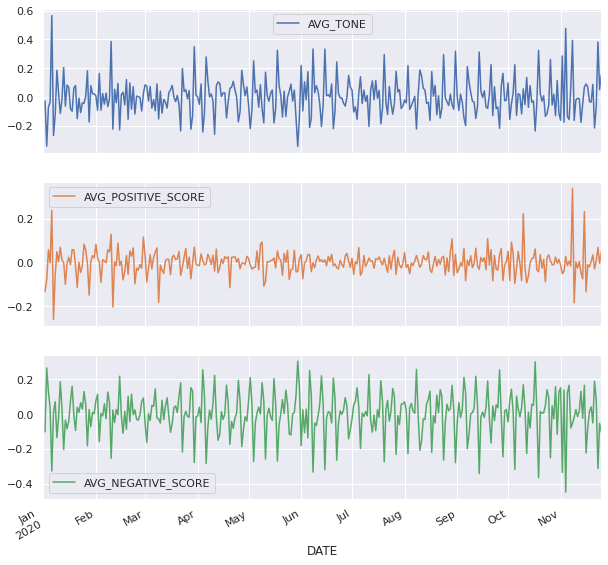

In [97]:
tone_diff = tone_df[["AVG_TONE", "AVG_POSITIVE_SCORE", "AVG_NEGATIVE_SCORE"]].diff()
tone_diff.plot(subplots=True, figsize=(10,10))

In [48]:
query="""
SELECT * from goldenfleece.sentiment.ftse100 order by Date
"""
ftse_df = client.query(query).to_dataframe()
ftse_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2019-09-20,7356.399902,7376.299805,7322.000000,7344.899902,7344.899902,1656288000
1,2019-09-23,7344.899902,7362.299805,7284.799805,7326.100098,7326.100098,489660300
2,2019-09-24,7326.100098,7349.000000,7281.899902,7291.399902,7291.399902,588772200
3,2019-09-25,7291.399902,7292.000000,7213.000000,7290.000000,7290.000000,704553100
4,2019-09-26,7290.000000,7387.100098,7277.200195,7351.100098,7351.100098,704707500


In [49]:
ftse_df = ftse_df.astype({"Date":"datetime64"}).set_index("Date") 
ftse_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2019-09-20 to 2020-11-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       300 non-null    float64
 1   High       300 non-null    float64
 2   Low        300 non-null    float64
 3   Close      300 non-null    float64
 4   Adj_Close  300 non-null    float64
 5   Volume     300 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 16.4 KB


In [72]:
adj_close = ftse_df.sort_index()["Adj_Close"]
adj_close_diff = adj_close.diff()

<AxesSubplot:xlabel='Date'>

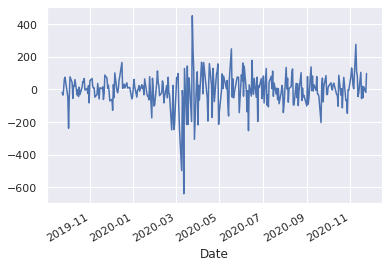

In [98]:
adj_close_diff.plot()

In [73]:
merged_df = tone_diff.merge(adj_close_diff, left_index=True, right_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229 entries, 2020-01-02 to 2020-11-24
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AVG_TONE            229 non-null    float64
 1   AVG_POSITIVE_SCORE  229 non-null    float64
 2   AVG_NEGATIVE_SCORE  229 non-null    float64
 3   Adj_Close           229 non-null    float64
dtypes: float64(4)
memory usage: 8.9 KB


In [74]:
merged_df.corr(method="pearson")["Adj_Close"].drop(index="Adj_Close")

AVG_TONE              0.144940
AVG_POSITIVE_SCORE    0.038874
AVG_NEGATIVE_SCORE   -0.147986
Name: Adj_Close, dtype: float64

#### Take the first difference of each time series and calculate correlation

<AxesSubplot:xlabel='Adj_Close', ylabel='AVG_TONE'>

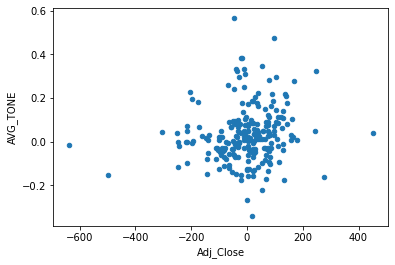

In [75]:
merged_df.plot.scatter(x="Adj_Close", y="AVG_TONE")

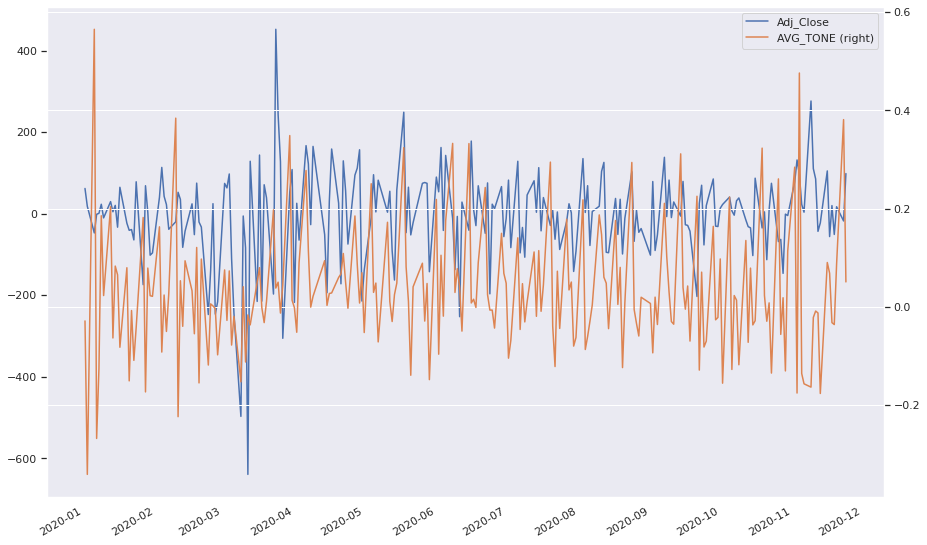

In [100]:
ax = merged_df[["Adj_Close", "AVG_TONE"]].plot(secondary_y="AVG_TONE", figsize=(15,10))

In [112]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

tone_cross_correlation = {lag:crosscorr(merged_df["AVG_TONE"], merged_df["Adj_Close"], lag) for lag in range(-10, 10)}

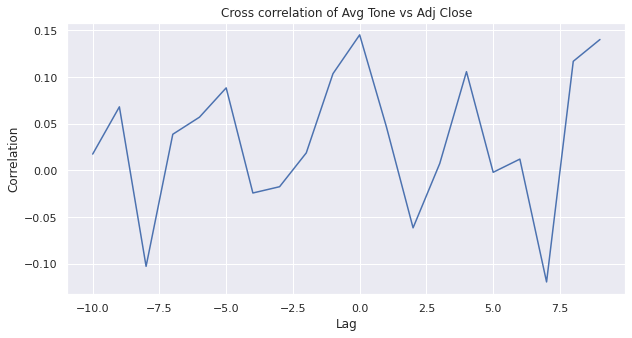

In [113]:
ax = pd.Series(tone_cross_correlation).plot(figsize=(10,5))
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation")
ax.set_title("Cross correlation of Avg Tone vs Adj Close");